## Series de tiempo con FB Prophet

Una buena fuente de documentación es:
https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-prophet-in-python-3

In [1]:
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
%matplotlib inline  
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
%pip install prophet

  Obtaining dependency information for prophet from https://files.pythonhosted.org/packages/88/d6/ebc199ba1fd99719c8680b3fb90663aa4888871364c69bbf9629148b9724/prophet-1.1.4-py3-none-win_amd64.whl.metadata
  Using cached prophet-1.1.4-py3-none-win_amd64.whl.metadata (3.7 kB)
  Using cached cmdstanpy-1.1.0-py3-none-any.whl (83 kB)
  Using cached LunarCalendar-0.0.9-py2.py3-none-any.whl (18 kB)
  Using cached convertdate-2.4.0-py3-none-any.whl (47 kB)
  Obtaining dependency information for holidays>=0.25 from https://files.pythonhosted.org/packages/e0/7e/9d3b9387ac87500ae215da875660d219f7734e0dbe9437898a7388f0855c/holidays-0.32-py3-none-any.whl.metadata
  Using cached holidays-0.32-py3-none-any.whl.metadata (16 kB)
  Using cached PyMeeus-0.5.12.tar.gz (5.8 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
      --------------------------------------- 0.0/1.4 MB 1.


[notice] A new release of pip is available: 23.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
# Python
import pandas as pd
import numpy as np
import datetime
from prophet import Prophet

In [14]:
def parse_date (x): 
    return datetime.datetime.strptime("0"+str(x), '%y-%m') 

In [15]:
def medir_rmse(actual, predicho):
    return sqrt(mean_squared_error(actual, predicho))

#measure_rmse([1,2],[1,3])

In [16]:
def division_entreno_prueba(datos, n_entreno):
    entreno = datos.iloc[:n_entreno]
    prueba = datos.iloc[n_entreno:]
    return entreno, prueba

In [17]:
def prediccion_prophet(series):
    series.head()
    modelo = Prophet(mcmc_samples = 500, seasonality_mode = 'multiplicative').fit(series);
    futuro = modelo.make_future_dataframe(periods = 1,freq = 'M')
    predicciones = modelo.predict(futuro)
    return predicciones.iloc[-1]["yhat"]

Validación hacia el frente para datos univariados

In [18]:
def validacion_al_frente(datos, n_entreno, cfg):
    predicciones = []
    # dividir el conjunto de datos
    entreno, prueba = division_entreno_prueba(datos, n_entreno)
    # grabar la historia con el conjunto de datos de entrenamiento
    historia = entreno
    # pasar por cada incremento de tiempo en el conjunto de prueba
    for i in range(len(prueba)):
        # ajustar el modelo a los datos y predecir los datos históricos
        yhat = prediccion_prophet(historia)
        # agregar el dato predicho en la lista de preducciones
        predicciones.append(yhat)
        # agregar la observación a la historia para la siguiente iteración
        historia.append(pd.DataFrame(prueba.iloc[i]))
    # estimar el error de las predicciones
    error = medir_rmse(prueba["y"], predicciones)
    return [error, predicciones]

In [19]:
def evaluar_modelo(datos, n_entreno, metodo, cfg, debug = False):
    resultado = None
    predicciones = None
    # convertir config a una llave
    llave = str(cfg)
    resultado, predicciones = validacion_al_frente(datos, n_entreno, metodo, cfg)
    if resultado is not None:
        print(f' > Modelo[{llave}] {resultado:.3f}')
    return (llave, resultado, predicciones)

In [20]:
def buscar_mejor_solucion(series, nombre, metodo = "prophet"):    
    datos = series

    resultados = []
    # división de datos
    n_entreno = int(len(datos)*0.8) # porcentaje usado para entrenar
    long_max = len(datos) - n_entreno
    print(f"Tamaño entreno {n_entreno} ")
    print(f"Tamaño prueba {long_max}")
    lista_cfg = [1]
    
    resultados = [evaluar_modelo(datos, n_entreno, metodo, cfg) for cfg in lista_cfg]
    
    # ordenar configs por error, ascendente
    resultados.sort(key=lambda tup: tup[1])


    print('terminado')
    # listar las tres configuraciones mejores
    for cfg, error, predicciones in resultados[:3]:
        print(cfg, error)

    
    #desplegar
    entreno, prueba = division_entreno_prueba(datos,n_entreno)
    prediccion = pd.DataFrame(list(entreno["y"]) + resultados[0][2])
    
    #####
    datos.set_index(['ds'],inplace=True)
    #prediccion.set_index(['ds'],inplace = True)
    prediccion.index = datos.index


    ax = pd.DataFrame(datos).plot(label="Original") # datos originales
    prediccion.plot(ax=ax, alpha=.7, figsize=(14,7))
    plt.savefig(f"{nombre}_{metodo}.png")
    plt.show()
    return [datos,prediccion]

In [21]:
def evaluar_prediccion(series, frecuencia = "M"):
    datos = series
    n_entreno = int(len(datos) * 0.8) # porcentaje usado para entreno
    long_max = len(datos) - n_entreno
    print(f"Tamaño entreno {n_entreno} ")
    print(f"Tamaño prueba {long_max} ")
    lista_cfg = [1]
    entreno, prueba = division_entreno_prueba(datos, n_entreno)
    modelo = Prophet(mcmc_samples = 500, seasonality_mode = 'multiplicative').fit(series);
    futuro = modelo.make_future_dataframe(periods = len(prueba),freq = frecuencia)
    predicciones = modelo.predict(futuro)
    modelo.plot(predicciones)
    rmse = medir_rmse(predicciones.iloc[len(entreno):len(series)]["yhat"], prueba["y"])
    print(f"RMSE: {rmse}")

# Evaluación multi-pasos

## Nacimientos Niñas

In [22]:
series = pd.read_csv('daily-total-female-births.csv', header=0, index_col=None)
series['ds']  = pd.to_datetime(series['Date'])
series[['y']] = series[['Births']].astype(float)
series = series[["ds","y"]]
series.head()

,ds,y
0,1959-01-01,35.0
1,1959-01-02,32.0
2,1959-01-03,30.0
3,1959-01-04,31.0
4,1959-01-05,44.0


Tamaño entreno 292 
Tamaño prueba 73 


16:32:00 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |██▊       | 00:00 Iteration:   1 / 500 [  0%]  (Warmup)



chain 1 |████▎     | 00:01 Iteration: 100 / 500 [ 20%]  (Warmup)


chain 1 |█████▋    | 00:02 Iteration: 200 / 500 [ 40%]  (Warmup)


chain 1 |███████▏  | 00:03 Iteration: 251 / 500 [ 50%]  (Sampling)

chain 1 |████████▌ | 00:03 Iteration: 350 / 500 [ 70%]  (Sampling)
chain 1 |██████████| 00:04 Iteration: 450 / 500 [ 90%]  (Sampling)


chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     

16:32:05 - cmdstanpy - INFO - CmdStan done processing.
16:32:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_


RMSE: 6.6437627585707375


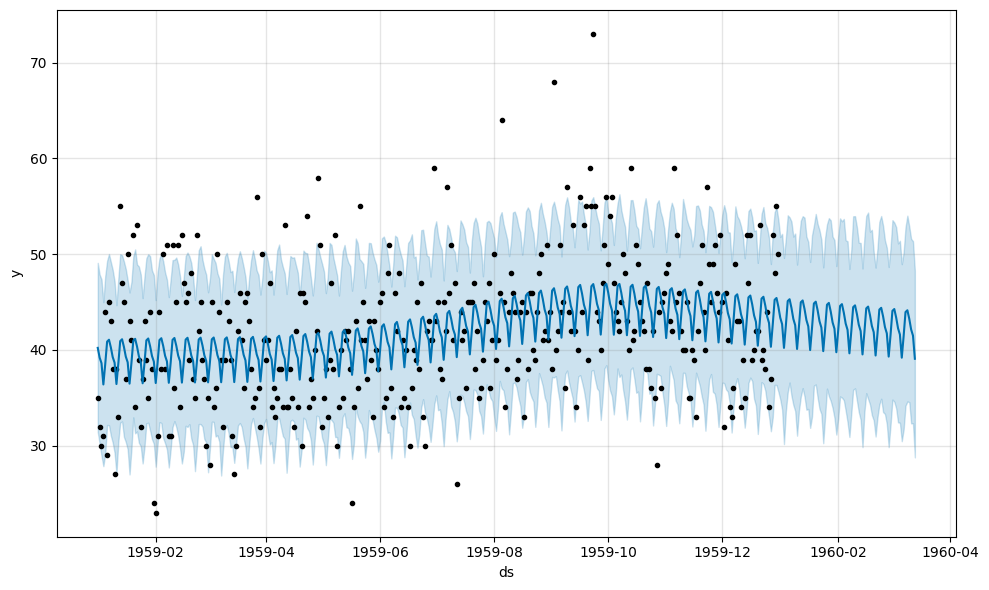

In [23]:
series = pd.read_csv('daily-total-female-births.csv', header=0, index_col=None)
series['ds']  = pd.to_datetime(series['Date'])
series[['y']] = series[['Births']].astype(float)
series = series[["ds","y"]]
evaluar_prediccion(series, "D")

## Shampoo

Tamaño entreno 28 
Tamaño prueba 8 


16:32:07 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |██▊       | 00:01 Iteration:   1 / 500 [  0%]  (Warmup)



chain 1 |████▎     | 00:02 Iteration: 100 / 500 [ 20%]  (Warmup)


chain 1 |█████▋    | 00:02 Iteration: 200 / 500 [ 40%]  (Warmup)

chain 1 |███████▏  | 00:03 Iteration: 251 / 500 [ 50%]  (Sampling)


chain 1 |██████████| 00:04 Iteration: 450 / 500 [ 90%]  (Sampling)





chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     


16:32:12 - cmdstanpy - INFO - CmdStan done processing.
16:32:12 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True i


RMSE: 40.61029203349057


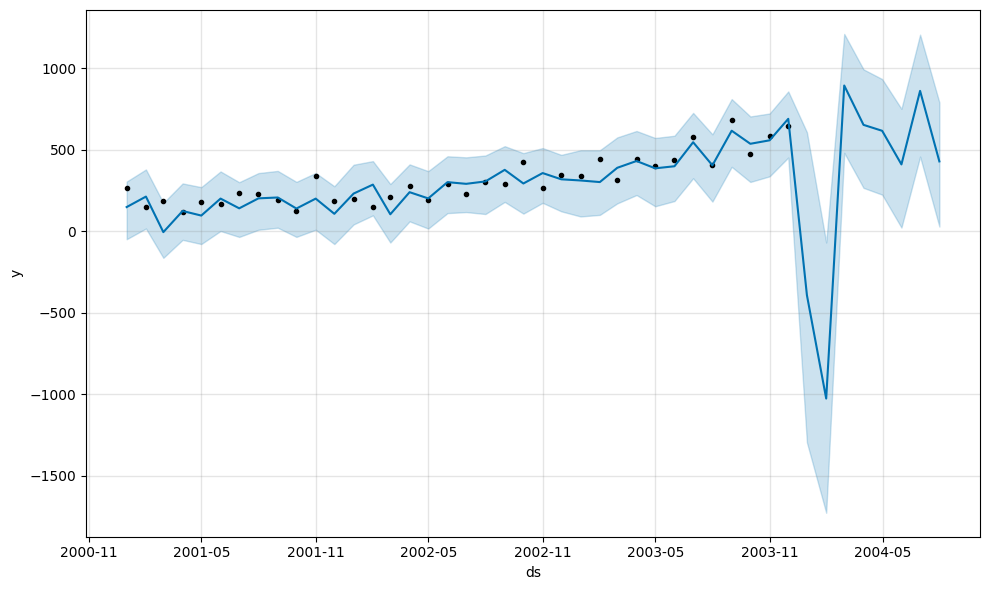

In [24]:
series = pd.read_csv('shampoo.csv', header=0)
series['ds']  = series['Month'].apply(lambda x: parse_date(x))
series[['y']] = series[['Sales']].astype(float)
series = series[["ds","y"]]
evaluar_prediccion(series)

## Temperaturas

Tamaño entreno 192 
Tamaño prueba 48 


16:32:14 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▊       | 00:01 Iteration:   1 / 500 [  0%]  (Warmup)



chain 1 |████▎     | 00:03 Iteration: 100 / 500 [ 20%]  (Warmup)


chain 1 |█████▋    | 00:04 Iteration: 200 / 500 [ 40%]  (Warmup)


chain 1 |███████▏  | 00:05 Iteration: 251 / 500 [ 50%]  (Sampling)

chain 1 |████████▌ | 00:06 Iteration: 350 / 500 [ 70%]  (Sampling)


chain 1 |██████████| 00:07 Iteration: 450 / 500 [ 90%]  (Sampling)


chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     


16:32:22 - cmdstanpy - INFO - CmdStan done processing.
16:32:22 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Sc


RMSE: 1.9212769242866148


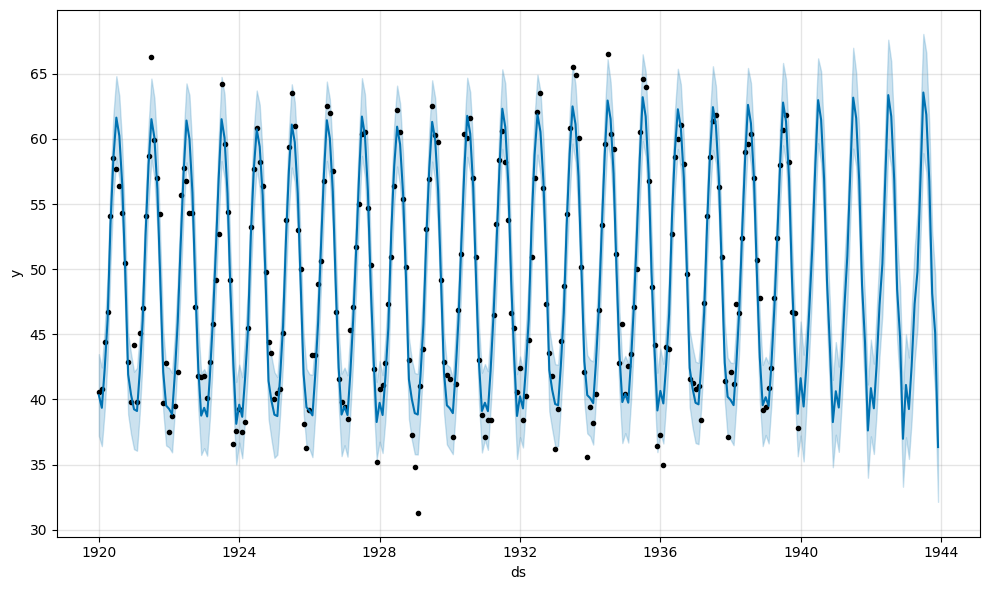

In [25]:
series = pd.read_csv('monthly-mean-temp.csv', header=0, index_col=None)
series['ds']  = pd.to_datetime(series['Month'])
series[['y']] = series[['Temperature']].astype(float)
series = series[["ds","y"]]
evaluar_prediccion(series)

## Ventas de carros

Tamaño entreno 86 
Tamaño prueba 22 


16:32:24 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |██▊       | 00:01 Iteration:   1 / 500 [  0%]  (Warmup)


chain 1 |████▎     | 00:02 Iteration: 100 / 500 [ 20%]  (Warmup)


chain 1 |█████▋    | 00:02 Iteration: 200 / 500 [ 40%]  (Warmup)




chain 1 |███████▏  | 00:03 Iteration: 251 / 500 [ 50%]  (Sampling)




chain 1 |████████▌ | 00:03 Iteration: 350 / 500 [ 70%]  (Sampling)
chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     


16:32:28 - cmdstanpy - INFO - CmdStan done processing.
16:32:28 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True i


RMSE: 1385.7064292273408


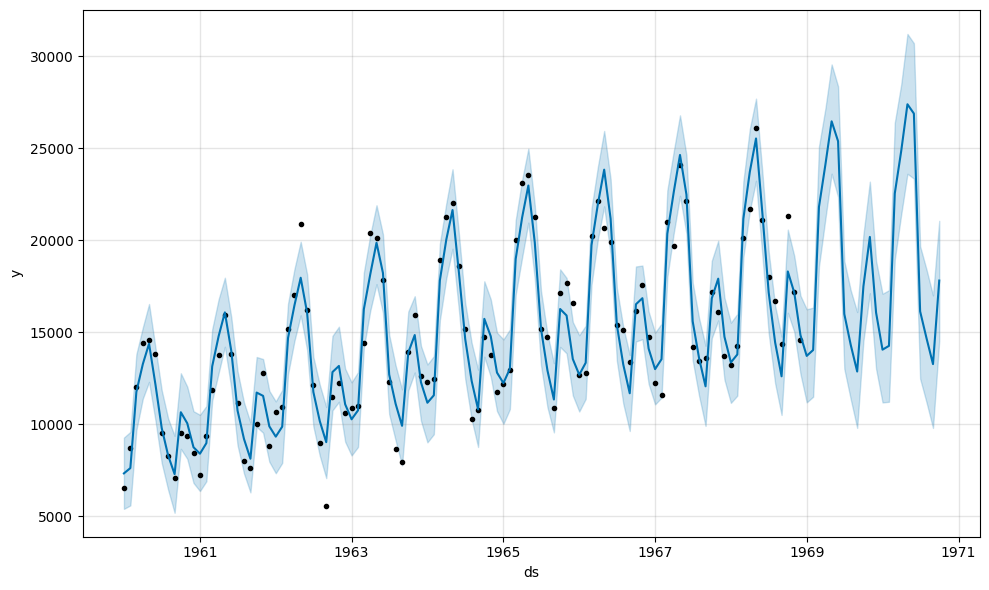

In [26]:
series = pd.read_csv('monthly-car-sales.csv', header=0,parse_dates=["Month"])
series['ds']  = series['Month']
series[['y']] = series[['Sales']].astype(float)
series = series[["ds","y"]]
evaluar_prediccion(series)

# Evaluación paso a paso (TODO)

Tamaño entreno 86 
Tamaño prueba 22 


16:32:30 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |██▊       | 00:01 Iteration:   1 / 500 [  0%]  (Warmup)


chain 1 |████▎     | 00:01 Iteration: 100 / 500 [ 20%]  (Warmup)


chain 1 |█████▋    | 00:01 Iteration: 200 / 500 [ 40%]  (Warmup)


chain 1 |███████▏  | 00:02 Iteration: 251 / 500 [ 50%]  (Sampling)

chain 1 |████████▌ | 00:02 Iteration: 350 / 500 [ 70%]  (Sampling)


chain 1 |██████████| 00:03 Iteration: 450 / 500 [ 90%]  (Sampling)
chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     


16:32:33 - cmdstanpy - INFO - CmdStan done processing.
16:32:33 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if 


RMSE: 1391.8717152809597


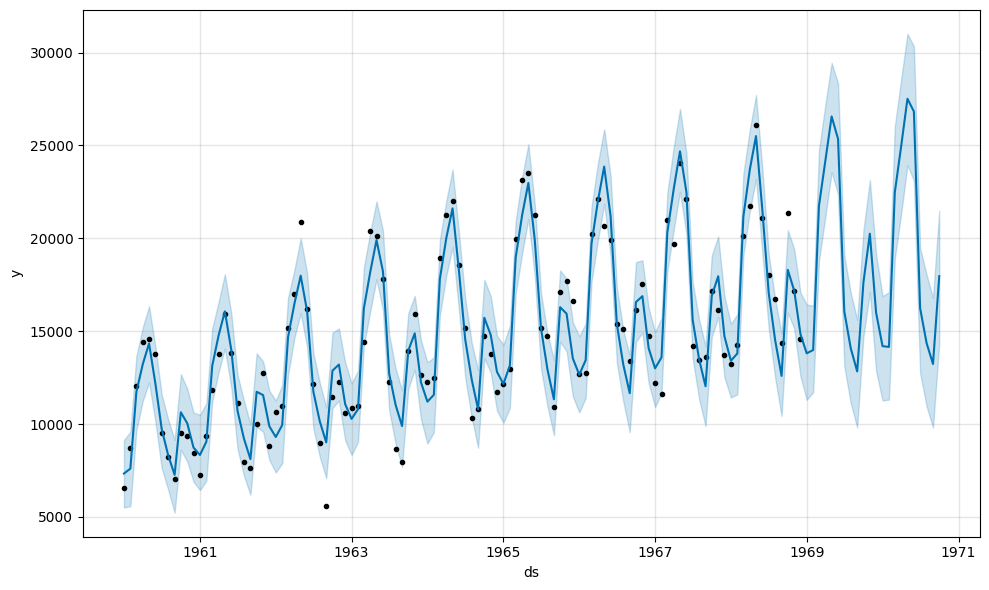

In [27]:
series = pd.read_csv('monthly-car-sales.csv', header=0, index_col=None)
series['ds']  = pd.to_datetime(series['Month'])
series[['y']] = series[['Sales']].astype(float)
series = series[["ds","y"]]
evaluar_prediccion(series)

# Demo simple

In [28]:
series = pd.read_csv('monthly-car-sales.csv', header = 0, index_col = None)
series['ds']  = pd.to_datetime(series['Month'])
series[['y']] = series[['Sales']].astype(float)
series = series[["ds","y"]]
series.head()

,ds,y
0,1960-01-01,6550.0
1,1960-02-01,8728.0
2,1960-03-01,12026.0
3,1960-04-01,14395.0
4,1960-05-01,14587.0


# Ajustar con Prophet

In [29]:
# Python
#modelo = Prophet()
modelo = Prophet(mcmc_samples = 500, seasonality_mode = 'multiplicative').fit(series);

16:32:36 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |██▊       | 00:01 Iteration:   1 / 500 [  0%]  (Warmup)


chain 1 |████▎     | 00:02 Iteration: 100 / 500 [ 20%]  (Warmup)


chain 1 |█████▋    | 00:02 Iteration: 200 / 500 [ 40%]  (Warmup)


chain 1 |███████▏  | 00:03 Iteration: 251 / 500 [ 50%]  (Sampling)





chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     


16:32:40 - cmdstanpy - INFO - CmdStan done processing.
16:32:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if 

# Predecir

In [30]:
series.tail()

,ds,y
103,1968-08-01,16722.0
104,1968-09-01,14385.0
105,1968-10-01,21342.0
106,1968-11-01,17180.0
107,1968-12-01,14577.0


In [31]:
futuro = modelo.make_future_dataframe(periods = 48, freq = "M")
predicciones = modelo.predict(futuro)
predicciones[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail()


,ds,yhat,yhat_lower,yhat_upper
151,1972-07-31,15735.792232,12286.168268,18993.451648
152,1972-08-31,14115.087722,11070.028630,17260.008060
153,1972-09-30,19634.043618,16220.617060,23345.204705
154,1972-10-31,21730.092119,17962.621508,25602.724137
155,1972-11-30,17545.155045,13896.450378,21069.655723


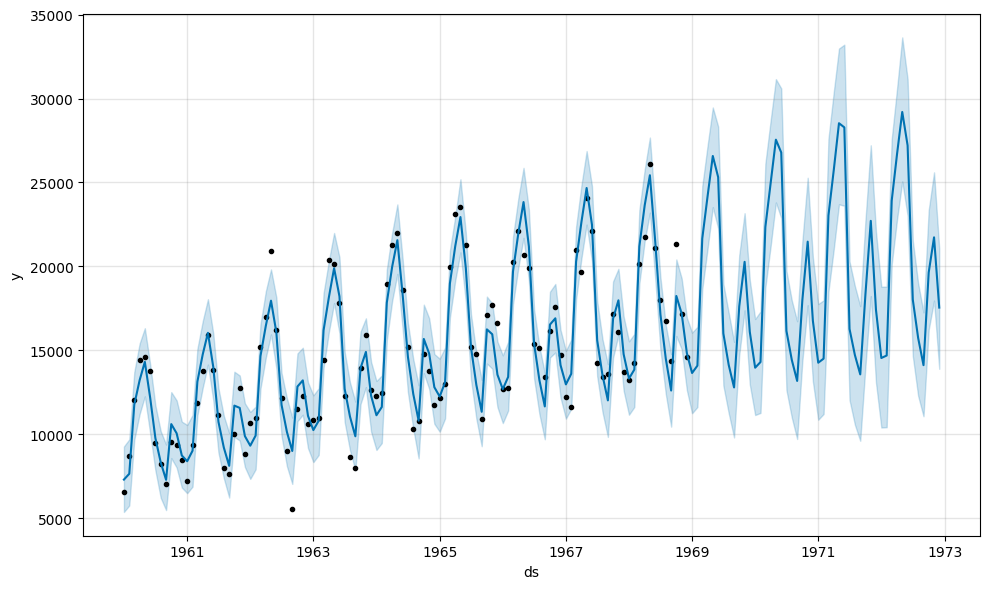

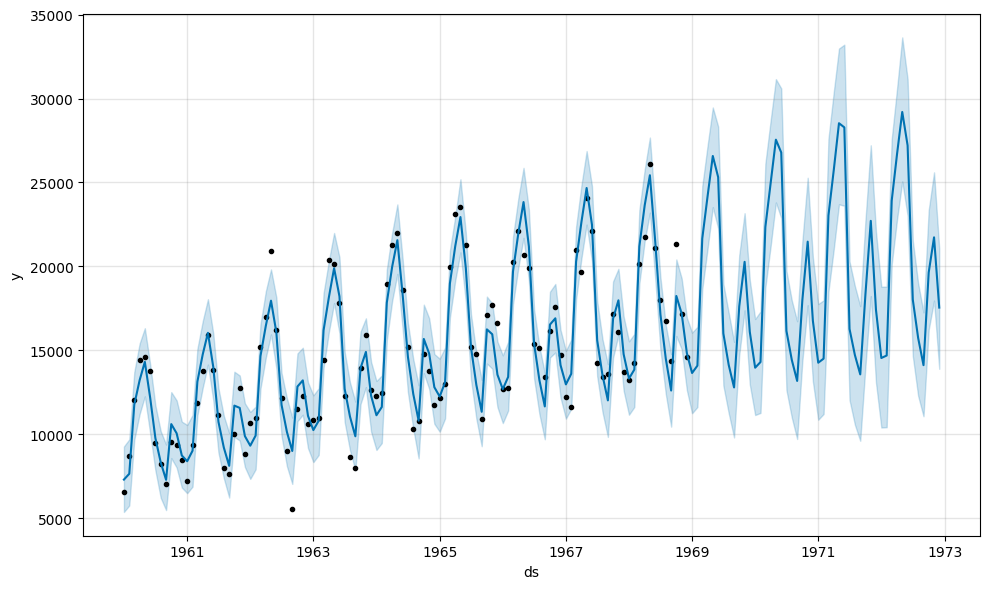

In [32]:
modelo.plot(predicciones)

# Mostrar los componentes estacionales

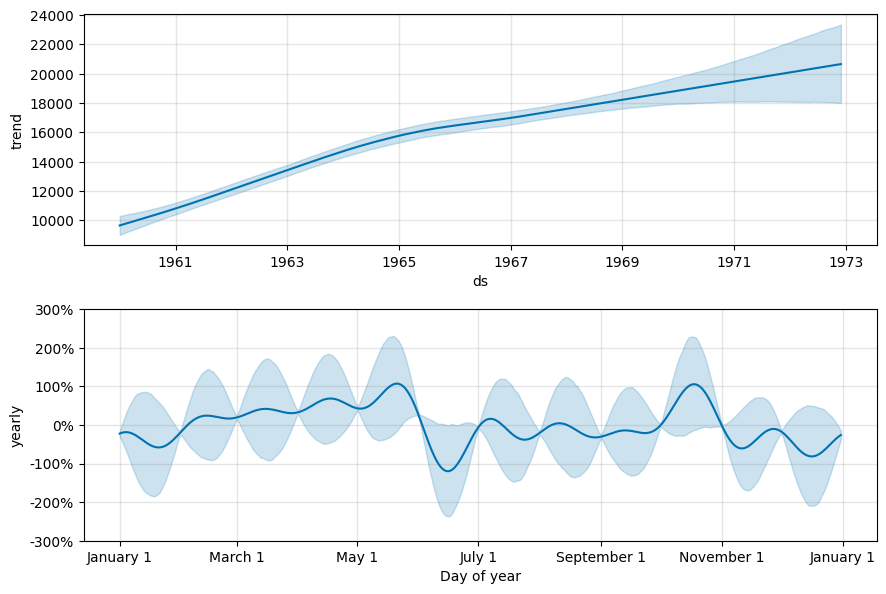

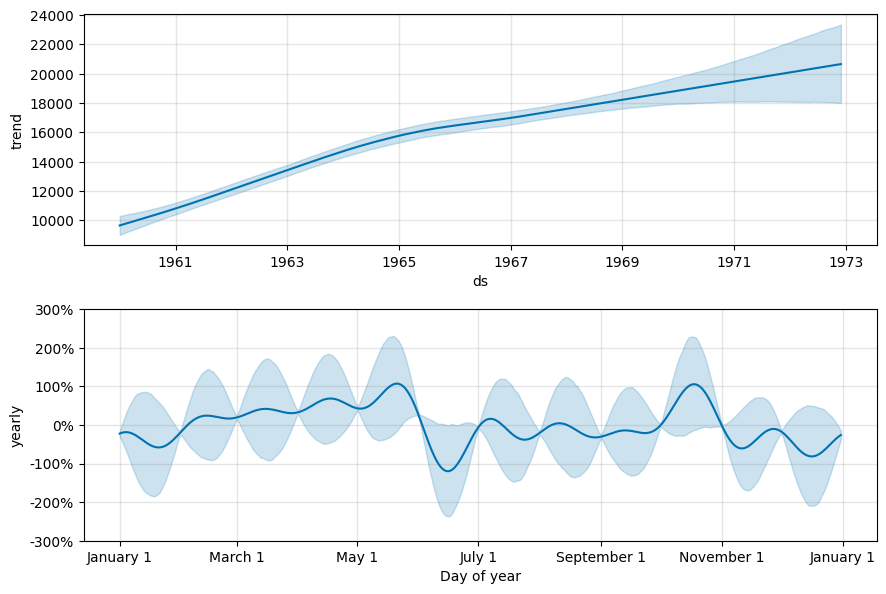

In [33]:
modelo.plot_components(predicciones)

In [34]:
from prophet.diagnostics import cross_validation
df_cv = cross_validation(modelo, horizon = '180 days')
df_cv.head()

  0%|          | 0/29 [00:00<?, ?it/s]16:32:43 - cmdstanpy - INFO - CmdStan start processing



































chain 1 |██████████| 00:02 Sampling completed

chain 2 |██████████| 00:02 Sampling completed
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     


16:32:46 - cmdstanpy - INFO - CmdStan done processing.
16:32:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
16:32:46 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 2 divergent transitions (0.8%)
	Chain 2 had 4 divergent transitions (1.6%)
	Chain 3 had 4 divergent transitions (1.6%)
	Chain 4 had 1 divergent transitions (0.4%)
	Use function "diagnose()" to see further information.


  3%|▎         | 1/29 [00:04<01:58,  4.22s/it]16:32:47 - cmdstanpy - INFO - CmdStan start processing






































chain 1 |██████████| 00:04 Sampling completed                     

chain 2 |██████████| 00:04 Sampling completed


chain 3 |██████████| 00:04 Sampling completed



chain 4 |██████████| 00:04 Sampling completed


16:32:51 - cmdstanpy - INFO - CmdStan done processing.
16:32:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
16:32:52 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 8 divergent transitions (3.2%)
	Chain 1 had 16 iterations at max treedepth (6.4%)
	Chain 2 had 5 divergent transitions (2.0%)
	Chain 4 had 1 divergent transitions (0.4%)
	Use function "diagnose()" to see further information.


  7%|▋         | 2/29 [00:09<02:16,  5.06s/it]16:32:53 - cmdstanpy - INFO - CmdStan start processing










































chain 1 |██████████| 00:05 Sampling completed
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     


16:32:58 - cmdstanpy - INFO - CmdStan done processing.
16:32:58 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 2 divergent transitions (0.8%)
	Chain 2 had 77 iterations at max treedepth (30.8%)
	Chain 4 had 44 iterations at max treedepth (17.6%)
	Use function "diagnose()" to see further information.


 10%|█         | 3/29 [00:16<02:33,  5.91s/it]16:33:00 - cmdstanpy - INFO - CmdStan start processing
















































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     


16:33:06 - cmdstanpy - INFO - CmdStan done processing.
16:33:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
16:33:06 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 5 divergent transitions (2.0%)
	Chain 2 had 162 iterations at max treedepth (64.8%)
	C

 14%|█▍        | 4/29 [00:24<02:49,  6.77s/it]16:33:08 - cmdstanpy - INFO - CmdStan start processing










































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     


16:33:13 - cmdstanpy - INFO - CmdStan done processing.
16:33:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
16:33:13 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 3 iterations at max treedepth (1.2%)
	Chain 4 had 11 iterations at max treedepth (4.4%

 17%|█▋        | 5/29 [00:31<02:45,  6.89s/it]16:33:15 - cmdstanpy - INFO - CmdStan start processing










































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     


16:33:19 - cmdstanpy - INFO - CmdStan done processing.
16:33:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
16:33:19 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 iterations at max treedepth (0.4%)
	Chain 4 had 1 iterations at max treedepth (0.4%)
	

 21%|██        | 6/29 [00:37<02:25,  6.31s/it]16:33:20 - cmdstanpy - INFO - CmdStan start processing










































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     


16:33:25 - cmdstanpy - INFO - CmdStan done processing.
16:33:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
16:33:25 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 3 had 2 iterations at max treedepth (0.8%)
	Use function "diagnose()" to see further information.


 24%|██▍       | 7/29 [00:43<02:20,  6.37s/it]16:33:27 - cmdstanpy - INFO - CmdStan start processing










































chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     


16:33:32 - cmdstanpy - INFO - CmdStan done processing.
16:33:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True i

 28%|██▊       | 8/29 [00:50<02:18,  6.59s/it]16:33:34 - cmdstanpy - INFO - CmdStan start processing










































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     


16:33:38 - cmdstanpy - INFO - CmdStan done processing.
16:33:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!


 31%|███       | 9/29 [00:56<02:06,  6.32s/it]16:33:39 - cmdstanpy - INFO - CmdStan start processing










































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     


16:33:43 - cmdstanpy - INFO - CmdStan done processing.
16:33:43 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!


 34%|███▍      | 10/29 [01:01<01:53,  5.95s/it]16:33:44 - cmdstanpy - INFO - CmdStan start processing










































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     


16:33:48 - cmdstanpy - INFO - CmdStan done processing.
16:33:48 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True i

 38%|███▊      | 11/29 [01:06<01:43,  5.72s/it]16:33:50 - cmdstanpy - INFO - CmdStan start processing










































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     


16:33:53 - cmdstanpy - INFO - CmdStan done processing.
16:33:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_cons

 41%|████▏     | 12/29 [01:11<01:34,  5.57s/it]16:33:55 - cmdstanpy - INFO - CmdStan start processing










































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     


16:33:59 - cmdstanpy - INFO - CmdStan done processing.
16:33:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True i

 45%|████▍     | 13/29 [01:17<01:28,  5.52s/it]16:34:00 - cmdstanpy - INFO - CmdStan start processing










































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     


16:34:04 - cmdstanpy - INFO - CmdStan done processing.
16:34:04 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True i

 48%|████▊     | 14/29 [01:22<01:19,  5.28s/it]16:34:05 - cmdstanpy - INFO - CmdStan start processing










































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     


16:34:08 - cmdstanpy - INFO - CmdStan done processing.
16:34:08 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_

 52%|█████▏    | 15/29 [01:26<01:10,  5.07s/it]16:34:10 - cmdstanpy - INFO - CmdStan start processing










































chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     


16:34:13 - cmdstanpy - INFO - CmdStan done processing.
16:34:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!


 55%|█████▌    | 16/29 [01:30<01:02,  4.84s/it]16:34:14 - cmdstanpy - INFO - CmdStan start processing










































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     


16:34:17 - cmdstanpy - INFO - CmdStan done processing.
16:34:17 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_cons

 59%|█████▊    | 17/29 [01:35<00:56,  4.73s/it]16:34:18 - cmdstanpy - INFO - CmdStan start processing










































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     


16:34:22 - cmdstanpy - INFO - CmdStan done processing.
16:34:22 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if 

 62%|██████▏   | 18/29 [01:40<00:51,  4.72s/it]16:34:23 - cmdstanpy - INFO - CmdStan start processing










































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     


16:34:27 - cmdstanpy - INFO - CmdStan done processing.
16:34:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!


 66%|██████▌   | 19/29 [01:45<00:47,  4.78s/it]16:34:28 - cmdstanpy - INFO - CmdStan start processing
















































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     


16:34:32 - cmdstanpy - INFO - CmdStan done processing.
16:34:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if 

 69%|██████▉   | 20/29 [01:50<00:43,  4.87s/it]16:34:33 - cmdstanpy - INFO - CmdStan start processing










































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     


16:34:37 - cmdstanpy - INFO - CmdStan done processing.
16:34:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True i

 72%|███████▏  | 21/29 [01:55<00:39,  4.91s/it]16:34:38 - cmdstanpy - INFO - CmdStan start processing










































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     


16:34:42 - cmdstanpy - INFO - CmdStan done processing.
16:34:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if 

 76%|███████▌  | 22/29 [02:00<00:34,  4.97s/it]16:34:43 - cmdstanpy - INFO - CmdStan start processing










































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     


16:34:47 - cmdstanpy - INFO - CmdStan done processing.
16:34:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if 

 79%|███████▉  | 23/29 [02:05<00:29,  4.96s/it]16:34:48 - cmdstanpy - INFO - CmdStan start processing










































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     


16:34:52 - cmdstanpy - INFO - CmdStan done processing.
16:34:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if 

 83%|████████▎ | 24/29 [02:10<00:25,  5.04s/it]16:34:53 - cmdstanpy - INFO - CmdStan start processing










































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     


16:34:57 - cmdstanpy - INFO - CmdStan done processing.
16:34:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if 

 86%|████████▌ | 25/29 [02:15<00:20,  5.12s/it]16:34:59 - cmdstanpy - INFO - CmdStan start processing










































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     


16:35:03 - cmdstanpy - INFO - CmdStan done processing.
16:35:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if 

 90%|████████▉ | 26/29 [02:21<00:15,  5.32s/it]16:35:05 - cmdstanpy - INFO - CmdStan start processing










































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     


16:35:09 - cmdstanpy - INFO - CmdStan done processing.
16:35:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if 

 93%|█████████▎| 27/29 [02:27<00:11,  5.58s/it]16:35:11 - cmdstanpy - INFO - CmdStan start processing










































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     


16:35:15 - cmdstanpy - INFO - CmdStan done processing.
16:35:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if 

 97%|█████████▋| 28/29 [02:33<00:05,  5.58s/it]16:35:16 - cmdstanpy - INFO - CmdStan start processing










































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     


16:35:20 - cmdstanpy - INFO - CmdStan done processing.
16:35:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if 

100%|██████████| 29/29 [02:38<00:00,  5.48s/it]


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,1961-08-01,-801.981724,-37897.688179,17321.096984,7975.0,1961-07-11
1,1961-09-01,-708.142050,-46559.864348,18606.580324,7610.0,1961-07-11
2,1961-10-01,-724.374818,-49943.730556,24741.742115,10015.0,1961-07-11
3,1961-11-01,-751.628958,-56178.709112,27519.280576,12759.0,1961-07-11
4,1961-12-01,-917.608320,-65342.197311,28314.789048,8816.0,1961-07-11


In [35]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,21 days,7.584809e+06,2754.053211,1811.929071,0.144918,0.074739,0.195688,0.882353
1,23 days,1.699445e+07,4122.432873,2481.137660,0.195676,0.083226,0.304314,0.882353
2,24 days,2.376748e+07,4875.189857,3049.599405,0.222929,0.083848,0.342047,0.882353
3,25 days,3.057143e+07,5529.143518,3605.153089,0.275721,0.104059,0.451335,0.882353
4,26 days,3.073750e+07,5544.141321,3651.098875,0.276317,0.104059,0.451856,0.882353
...,...,...,...,...,...,...,...,...
110,174 days,2.623824e+07,5122.327163,2719.164667,0.187198,0.048420,0.302907,0.764706
111,175 days,3.484845e+07,5903.257474,3389.847994,0.242336,0.058949,0.416477,0.764706
112,177 days,3.733663e+07,6110.370461,3720.053655,0.271534,0.058949,0.438329,0.764706
113,179 days,3.774527e+07,6143.717585,3905.339438,0.282414,0.114092,0.450042,0.735294


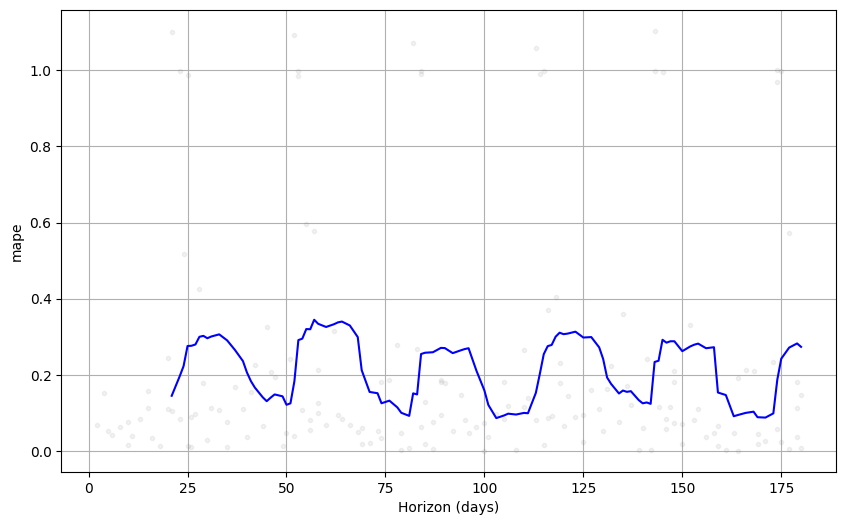

In [36]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric = 'mape')